# Лабораторная работа №2

## Выполнила: Ли Алина гр. 932001
### Вариант 4

In [1]:
import pandas as pd
import matplotlib.pyplot as plt #импорт модуля для графиков
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score
from keras.layers import SimpleRNN
from keras.layers import Dense,LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Загрузка данных из файла CSV
data = pd.read_csv('Yakutsk.csv')

In [111]:
# Выделение первых 5 и последних 5 записей
first_5 = data.head(5)
last_5 = data.tail(5)

# Вывод первых 5 записей в виде красивой таблицы
print("Первые 5 записей:")
display(first_5.style)

# Вывод последних 5 записей в виде красивой таблицы
print("Последние 5 записей:")
display(last_5.style)

Первые 5 записей:


,LocalTime,T,P0,P,U,DD
0,10/19/2020 17:00,-7.000000,745.900000,758.200000,68.000000,Ветер
1,10/19/2020 16:30,-6.000000,746.000000,758.200000,63.000000,Ветер
2,10/19/2020 16:00,-5.000000,746.000000,758.200000,58.000000,Ветер
3,10/19/2020 15:30,-4.000000,746.100000,758.200000,59.000000,Ветер
4,10/19/2020 15:00,-4.000000,746.100000,758.200000,54.000000,Ветер


Последние 5 записей:


,LocalTime,T,P0,P,U,DD
116046,10/01/2012 04:00,2.000000,742.800000,754.600000,87.000000,Ветер
116047,10/01/2012 03:00,2.000000,743.600000,755.400000,87.000000,Ветер
116048,10/01/2012 02:00,2.000000,743.600000,755.400000,87.000000,Ветер
116049,10/01/2012 01:00,2.000000,744.400000,756.200000,87.000000,Ветер
116050,10/01/2012 00:00,2.000000,744.400000,756.200000,87.000000,Ветер


In [112]:
data.describe()

,T,P0,P,U
count,116050.000000,116049.000000,116049.000000,116048.000000
mean,-8.092632,748.080996,760.517001,66.698022
std,21.679891,6.743260,7.464018,17.645702
min,-50.000000,726.800000,738.100000,8.000000
25%,-29.000000,743.400000,755.400000,57.000000
50%,-4.000000,747.700000,759.700000,68.000000
75%,11.000000,752.400000,765.000000,78.000000
max,35.000000,773.400000,787.700000,100.000000


In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116051 entries, 0 to 116050
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   LocalTime  116051 non-null  object 
 1   T          116050 non-null  float64
 2   P0         116049 non-null  float64
 3   P          116049 non-null  float64
 4   U          116048 non-null  float64
 5   DD         116048 non-null  object 
dtypes: float64(4), object(2)
memory usage: 5.3+ MB


In [3]:
print(data.isnull().sum())

LocalTime    0
T            1
P0           2
P            2
U            3
DD           3
dtype: int64


In [3]:
data = data.dropna()

In [5]:
print(f"DD: {data['DD'].unique()}")

DD: ['Ветер' 'Штиль' 'Переменное направление']


In [4]:
dict = {'Ветер':1,'Штиль':2,'Переменное направление':3}
data['DD'] = data['DD'].map(dict)
data.head(5)

,LocalTime,T,P0,P,U,DD
0,10/19/2020 17:00,-7.0,745.9,758.2,68.0,1
1,10/19/2020 16:30,-6.0,746.0,758.2,63.0,1
2,10/19/2020 16:00,-5.0,746.0,758.2,58.0,1
3,10/19/2020 15:30,-4.0,746.1,758.2,59.0,1
4,10/19/2020 15:00,-4.0,746.1,758.2,54.0,1


In [7]:
print(data.columns)

Index(['LocalTime', 'T', 'P0', 'P', 'U', 'DD'], dtype='object')


In [66]:
df=data[['LocalTime','T']]

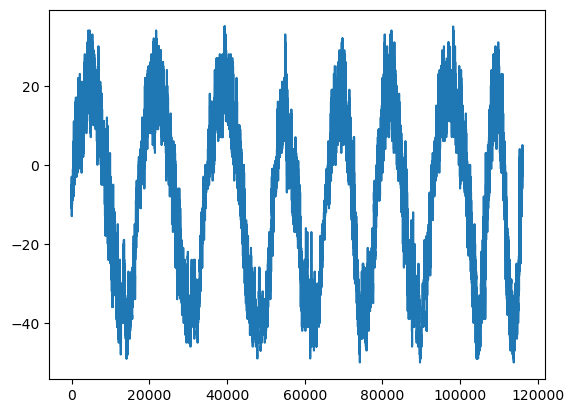

In [120]:
plt.plot(range(1,len(df['T'].values)+1),df['T'].values)

In [67]:
min_max_scaler = MinMaxScaler()
df = data['T'].values
df = min_max_scaler.fit_transform(df.reshape(-1, 1))

In [68]:
print(df.shape)
df = df.flatten()
print(df.shape)

(116044, 1)
(116044,)


window = 15: Определяет размер окна. В данном контексте, скользящее окно будет содержать 15 последовательных элементов данных.

n_samples = data.shape[0] - window: Вычисляет общее количество образцов, которые можно создать, вычитая размер окна из общего числа элементов в данных. Это связано с тем, что для создания каждой последовательной выборки используется окно фиксированного размера.

n_train_samples = round(0.7 * n_samples): Вычисляет количество образцов для обучающего набора данных, используя 70% от общего числа образцов. Здесь round используется для округления до целого числа, так как количество образцов должно быть целым.

n_val_samples = round(0.15 * n_samples): Вычисляет количество образцов для валидационного набора данных, используя 15% от общего числа образцов.

n_test_samples = n_samples - n_train_samples - n_val_samples: Вычисляет количество образцов для тестового набора данных, вычитая количество образцов в обучающем и валидационном наборах из общего числа образцов.

print('Train = ', n_train_samples, 'Validation = ', n_val_samples, 'Test = ', n_test_samples): Выводит количество образцов для обучающего, валидационного и тестового наборов данных.

In [69]:
window = 15

n_samples = df.shape[0] - window
n_train_samples = round(0.7 * n_samples)
n_val_samples = round(0.15 * n_samples)
n_test_samples = n_samples - n_train_samples - n_val_samples
print('Train = ', n_train_samples)
print('Validation = ', n_val_samples)
print('Test = ', n_test_samples)

Train =  81220
Validation =  17404
Test =  17405


In [70]:
X_train=np.zeros((n_train_samples,window))
y_train=np.zeros(n_train_samples)
X_val=np.zeros((n_val_samples,window))
y_val=np.zeros(n_val_samples)
X_test=np.zeros((n_test_samples,window))
y_test=np.zeros(n_test_samples)

для каждого дня в окне j, записываем значение температуры,
записываем значение температуры на следующий день как целевую переменную

Этот метод создает последовательные окна данных, где X содержит предыдущие значения (по размеру окна), а y содержит соответствующие следующие значения (целевую переменную).

In [71]:
for i in range(n_train_samples):
    for j in range(window):
        X_train[i,j]=df[i+j]
    y_train[i]=df[i+window]
       
for i in range(n_val_samples):
    for j in range(window):
        X_val[i,j]=df[n_train_samples+i+j]
    y_val[i]=df[n_train_samples+i+window]

for i in range(n_test_samples):
    for j in range(window):
        X_test[i,j]=df[n_train_samples+n_val_samples+i+j]
    y_test[i]=df[n_train_samples+n_val_samples+i+window]

# <b>1. Регрессор, использующий слой RNN в качестве скрытого слоя</b>

In [72]:
simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(10,activation='relu',input_shape=(window,1)))
simple_rnn_model.add(Dense(1,activation='linear'))

In [73]:
simple_rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [75]:
simple_rnn_model.compile(loss='mse',optimizer='adam',metrics='mae')

In [76]:
history = simple_rnn_model.fit(X_train, y_train, batch_size=25, epochs=40,validation_data=(X_val,y_val))
history_dict = history.history

Epoch 1/40
3249/3249 [==============================] - 7s 2ms/step - loss: 0.0017 - mae: 0.0133 - val_loss: 1.4235e-04 - val_mae: 0.0086
Epoch 2/40
3249/3249 [==============================] - 7s 2ms/step - loss: 1.2225e-04 - mae: 0.0079 - val_loss: 1.2867e-04 - val_mae: 0.0082
Epoch 3/40
3249/3249 [==============================] - 7s 2ms/step - loss: 1.1202e-04 - mae: 0.0075 - val_loss: 1.1460e-04 - val_mae: 0.0075
Epoch 4/40
3249/3249 [==============================] - 7s 2ms/step - loss: 1.0185e-04 - mae: 0.0071 - val_loss: 1.0423e-04 - val_mae: 0.0071
Epoch 5/40
3249/3249 [==============================] - 7s 2ms/step - loss: 9.8273e-05 - mae: 0.0070 - val_loss: 1.0926e-04 - val_mae: 0.0073
Epoch 6/40
3249/3249 [==============================] - 7s 2ms/step - loss: 9.8543e-05 - mae: 0.0070 - val_loss: 1.0965e-04 - val_mae: 0.0073
Epoch 7/40
3249/3249 [==============================] - 7s 2ms/step - loss: 9.7703e-05 - mae: 0.0070 - val_loss: 1.0352e-04 - val_mae: 0.0073
Epoch 8/40

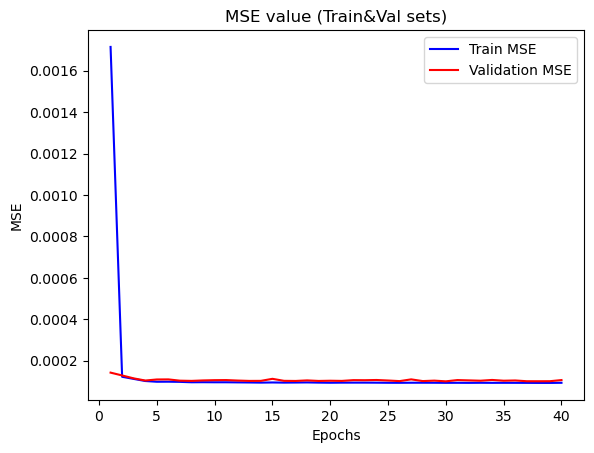

In [77]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Train MSE')
plt.plot(epochs, val_loss_values, 'r', label='Validation MSE')
plt.title('MSE value (Train&Val sets)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

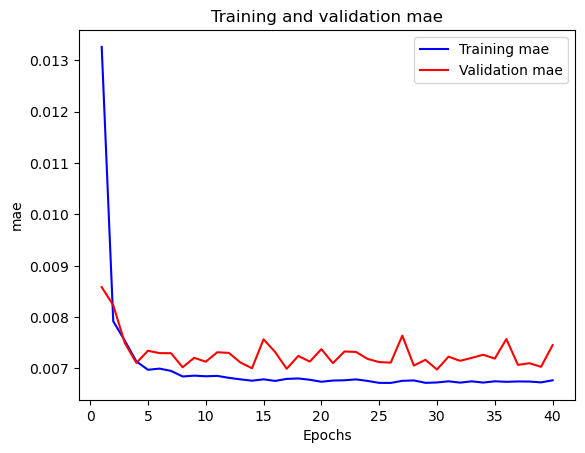

In [78]:
plt.clf()
acc_values = history_dict['mae']
val_acc_values = history_dict['val_mae']
plt.plot(epochs, acc_values, 'b', label='Training mae')
plt.plot(epochs, val_acc_values, 'r', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [79]:
y_pred = simple_rnn_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))
print('MAE = ', round(mean_absolute_error(y_true=y_test_inv, y_pred=y_pred_inv), 3), ' K degrees')
print('R2-score = ', round(r2_score(y_test_inv, y_pred_inv), 3))

544/544 [==============================] - 1s 1ms/step
MAE =  0.748  K degrees
R2-score =  0.998


### MSE, MAE, R2 

In [80]:
y_pred = simple_rnn_model.predict(X_test)  # X_test - тестовые данные
y_true = y_test  # y_test - фактические значения тестовых данных

# Вычисление MSE
mse1 = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse1}')

# Вычисление MAE
mae1 = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae1}')

# Вычисление R^2
r2_1 = r2_score(y_true, y_pred)
print(f'R-squared (R^2): {r2_1}')


544/544 [==============================] - 1s 980us/step
Mean Squared Error (MSE): 0.0001417474861460949
Mean Absolute Error (MAE): 0.008800544166989681
R-squared (R^2): 0.9977601059314142


## <b>Пример2</b>

In [5]:
data2=data

In [6]:
data2 = data2.drop('LocalTime', axis=1)
data2

,T,P0,P,U,DD
0,-7.0,745.9,758.2,68.0,1
1,-6.0,746.0,758.2,63.0,1
2,-5.0,746.0,758.2,58.0,1
3,-4.0,746.1,758.2,59.0,1
4,-4.0,746.1,758.2,54.0,1
...,...,...,...,...,...
116046,2.0,742.8,754.6,87.0,1
116047,2.0,743.6,755.4,87.0,1
116048,2.0,743.6,755.4,87.0,1
116049,2.0,744.4,756.2,87.0,1


In [8]:
selected_columns = ['T', 'P0', 'P', 'U', 'DD']
data2 = data2[selected_columns]
scaler = MinMaxScaler()
data2 = scaler.fit_transform(data2)

In [9]:
print(data2.shape)
data2 = data2.flatten()
print(data2.shape)

(116044, 5)
(580220,)


In [10]:
window2 = 10

n_samples2 = data2.shape[0] - window2
n_train_samples2 = round(0.6 * n_samples2)
n_val_samples2 = round(0.2 * n_samples2)
n_test_samples2 = n_samples2 - n_train_samples2 - n_val_samples2
print('Train = ', n_train_samples2)
print('Validation = ', n_val_samples2)
print('Test = ', n_test_samples2)

Train =  348126
Validation =  116042
Test =  116042


In [11]:
X_train2 = np.zeros((n_train_samples2, window2, len(selected_columns)))
y_train2 = np.zeros(n_train_samples2)
X_val2 = np.zeros((n_val_samples2, window2, len(selected_columns)))
y_val2 = np.zeros(n_val_samples2)
X_test2 = np.zeros((n_test_samples2, window2, len(selected_columns)))
y_test2 = np.zeros(n_test_samples2)

In [12]:
for i in range(n_train_samples2):
    for j in range(window2):
        X_train2[i,j]=data2[i+j]
    y_train2[i]=data2[i+window2]
       
for i in range(n_val_samples2):
    for j in range(window2):
        X_val2[i,j]=data2[n_train_samples2+i+j]
    y_val2[i]=data2[n_train_samples2+i+window2]

for i in range(n_test_samples2):
    for j in range(window2):
        X_test2[i,j]=data2[n_train_samples2+n_val_samples2+i+j]
    y_test2[i]=data2[n_train_samples2+n_val_samples2+i+window2]

In [39]:
print(X_train2.shape)

(348126, 10, 5)


In [13]:
simple_rnn_model2 = Sequential()
simple_rnn_model2.add(SimpleRNN(50,activation='relu',input_shape=(window2,5)))
simple_rnn_model2.add(Dense(1,activation='linear'))

In [14]:
simple_rnn_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2800      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2851 (11.14 KB)
Trainable params: 2851 (11.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
simple_rnn_model2.compile(loss='mse',optimizer='adam',metrics='mae')

In [16]:
history = simple_rnn_model2.fit(X_train2, y_train2, batch_size=25, epochs=40,validation_data=(X_val2,y_val2))
history_dict2 = history.history

Epoch 1/40
13926/13926 [==============================] - 26s 2ms/step - loss: 0.0044 - mae: 0.0318 - val_loss: 0.0053 - val_mae: 0.0347
Epoch 2/40
13926/13926 [==============================] - 25s 2ms/step - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0049 - val_mae: 0.0287
Epoch 3/40
13926/13926 [==============================] - 25s 2ms/step - loss: 0.0039 - mae: 0.0275 - val_loss: 0.0048 - val_mae: 0.0293
Epoch 4/40
13926/13926 [==============================] - 25s 2ms/step - loss: 0.0039 - mae: 0.0268 - val_loss: 0.0050 - val_mae: 0.0355
Epoch 5/40
13926/13926 [==============================] - 25s 2ms/step - loss: 0.0038 - mae: 0.0263 - val_loss: 0.0048 - val_mae: 0.0277
Epoch 6/40
13926/13926 [==============================] - 25s 2ms/step - loss: 0.0038 - mae: 0.0260 - val_loss: 0.0048 - val_mae: 0.0281
Epoch 7/40
13926/13926 [==============================] - 25s 2ms/step - loss: 0.0038 - mae: 0.0256 - val_loss: 0.0047 - val_mae: 0.0283
Epoch 8/40
13926/13926 [=================

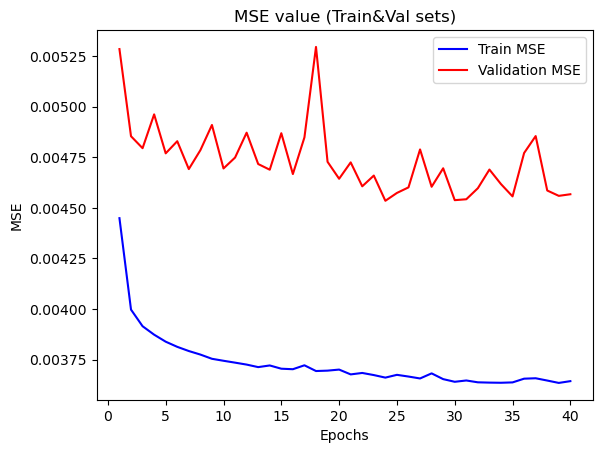

In [17]:
loss_values = history_dict2['loss']
val_loss_values = history_dict2['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Train MSE')
plt.plot(epochs, val_loss_values, 'r', label='Validation MSE')
plt.title('MSE value (Train&Val sets)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

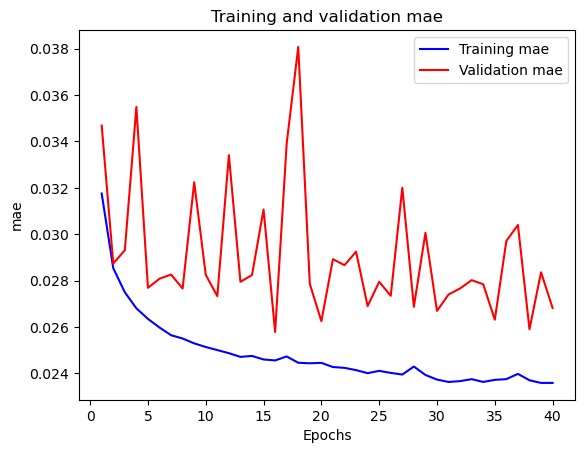

In [18]:
plt.clf()
acc_values = history_dict2['mae']
val_acc_values = history_dict2['val_mae']
plt.plot(epochs, acc_values, 'b', label='Training mae')
plt.plot(epochs, val_acc_values, 'r', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [23]:
# Обучите scaler на ваших данных
min_max_scaler.fit(y_train2.reshape(-1, 1))

# Используйте scaler для преобразования ваших данных
y_pred = simple_rnn_model2.predict(X_test2)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test2.reshape(-1,1))

print('MAE = ', round(mean_absolute_error(y_true=y_test_inv, y_pred=y_pred_inv), 3), ' K degrees')
print('R2-score = ', round(r2_score(y_test_inv, y_pred_inv), 3))

3627/3627 [==============================] - 3s 928us/step
MAE =  0.028  K degrees
R2-score =  0.929


In [37]:
day_index = 10

x = X_test2[day_index]  # входные данные для выбранного дня
x = x.reshape((1,) + x.shape) 
y_pred = simple_rnn_model2.predict(x)  # прогноз
y_pred_inv = min_max_scaler.inverse_transform(y_pred)  # прогноз обратно в исходные единицы


y_real = y_test2[day_index]  # реальная температура для выбранного дня
y_real_inv = min_max_scaler.inverse_transform(y_real.reshape(-1, 1)) 

# Сравните прогнозируемую и реальную температуру
print('Predicted temperature:', y_pred_inv[0, 0])
print('Real temperature:', y_real_inv[0, 0])


1/1 [==============================] - 0s 15ms/step
Predicted temperature: 0.6955087
Real temperature: 0.7173913043478262


### MSE, MAE, R2 

In [65]:
y_pred = simple_rnn_model2.predict(X_test2) 
y_true = y_test2

# Вычисление MSE
mse2 = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse2}')

# Вычисление MAE
mae2 = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae2}')

# Вычисление R^2
r2_2 = r2_score(y_true, y_pred)
print(f'R-squared (R^2): {r2_2}')


3627/3627 [==============================] - 3s 937us/step
Mean Squared Error (MSE): 0.005066024064976277
Mean Absolute Error (MAE): 0.028395376126685714
R-squared (R^2): 0.928994241007753


### Сравнение

Model Evaluation Results:
  Metric   Model 1   Model 2
0    MSE  0.000142  0.005066
1    MAE  0.008801  0.028395
2    R^2  0.997760  0.928994


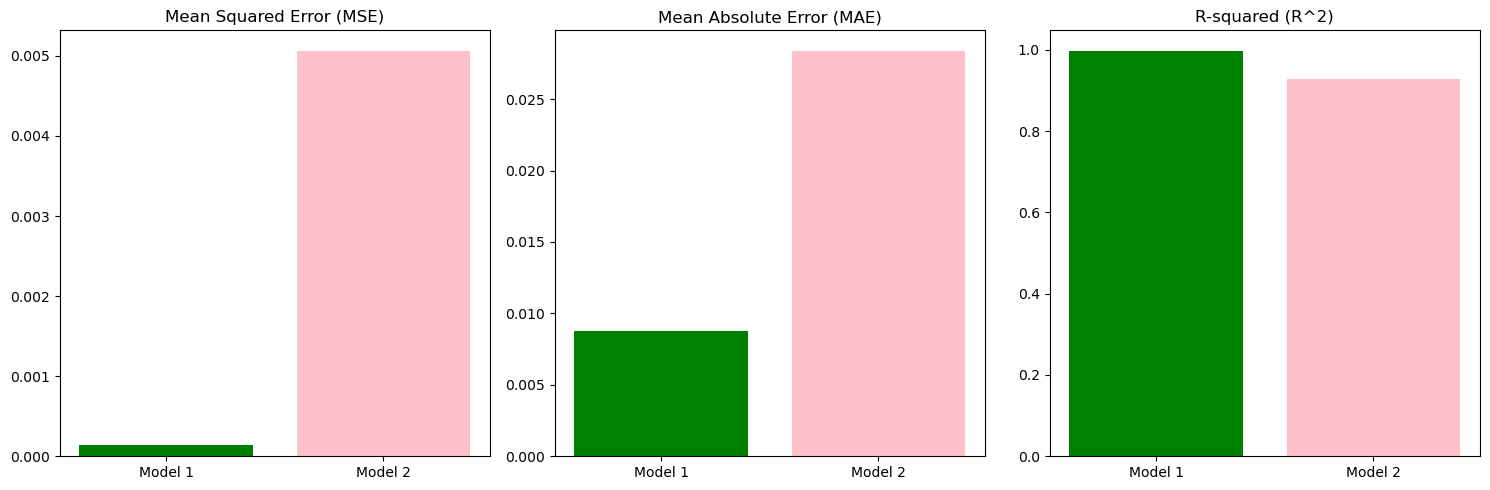

In [81]:
results = pd.DataFrame({'Metric': ['MSE', 'MAE', 'R^2'],
                        'Model 1': [mse1, mae1, r2_1],
                        'Model 2': [mse2, mae2, r2_2]})

mse = [mse1, mse2]
mae = [mae1, mae2]
r2 = [r2_1, r2_2]

colors = ['green', 'pink']
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.bar(['Model 1', 'Model 2'], mse, color=colors)
plt.title('Mean Squared Error (MSE)')

plt.subplot(132)
plt.bar(['Model 1', 'Model 2'], mae, color=colors)
plt.title('Mean Absolute Error (MAE)')

plt.subplot(133)
plt.bar(['Model 1', 'Model 2'], r2, color=colors)
plt.title('R-squared (R^2)')

plt.tight_layout()

print("Model Evaluation Results:")
print(results)
plt.show()

# <b>2. Регрессор, ячейку LSTM (или GRU) в скрытом слое</b>

In [87]:
model = Sequential()
model.add(LSTM(10,input_shape=(window,1)))
model.add(Dense(1,activation='linear'))

In [88]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 10)                480       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [89]:
model.compile(loss='mse',optimizer='adam',metrics='mae')

In [90]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30,validation_data=(X_val,y_val))
history_dict3 = history.history

Epoch 1/30
2539/2539 [==============================] - 11s 4ms/step - loss: 0.0010 - mae: 0.0173 - val_loss: 1.7764e-04 - val_mae: 0.0097
Epoch 2/30
2539/2539 [==============================] - 9s 3ms/step - loss: 1.3206e-04 - mae: 0.0083 - val_loss: 1.3165e-04 - val_mae: 0.0085
Epoch 3/30
2539/2539 [==============================] - 9s 4ms/step - loss: 1.1018e-04 - mae: 0.0075 - val_loss: 1.2147e-04 - val_mae: 0.0082
Epoch 4/30
2539/2539 [==============================] - 9s 3ms/step - loss: 1.0155e-04 - mae: 0.0072 - val_loss: 1.0396e-04 - val_mae: 0.0072
Epoch 5/30
2539/2539 [==============================] - 9s 4ms/step - loss: 9.7497e-05 - mae: 0.0070 - val_loss: 1.2543e-04 - val_mae: 0.0085
Epoch 6/30
2539/2539 [==============================] - 9s 4ms/step - loss: 9.6323e-05 - mae: 0.0070 - val_loss: 1.0171e-04 - val_mae: 0.0072
Epoch 7/30
2539/2539 [==============================] - 10s 4ms/step - loss: 9.4649e-05 - mae: 0.0069 - val_loss: 1.1149e-04 - val_mae: 0.0077
Epoch 8/

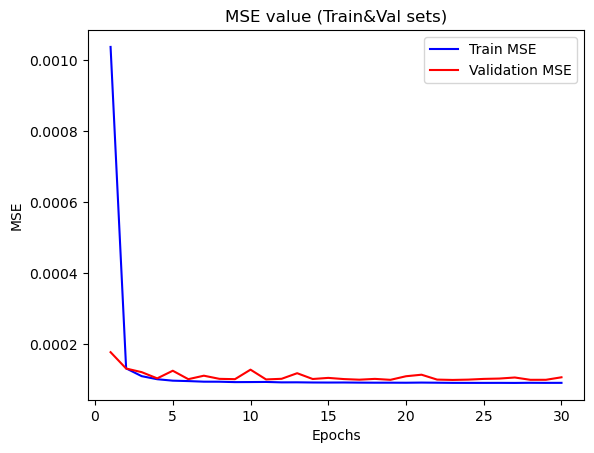

In [91]:
loss_values = history_dict3['loss']
val_loss_values = history_dict3['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Train MSE')
plt.plot(epochs, val_loss_values, 'r', label='Validation MSE')
plt.title('MSE value (Train&Val sets)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

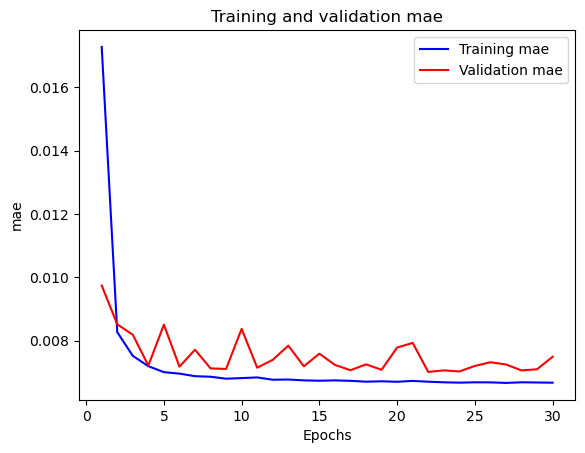

In [92]:
plt.clf()
acc_values = history_dict3['mae']
val_acc_values = history_dict3['val_mae']
plt.plot(epochs, acc_values, 'b', label='Training mae')
plt.plot(epochs, val_acc_values, 'r', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [93]:
y_pred = model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))
print('MAE = ', round(mean_absolute_error(y_true=y_test_inv, y_pred=y_pred_inv), 3), ' K degrees')
print('R2-score = ', round(r2_score(y_test_inv, y_pred_inv), 3))

544/544 [==============================] - 1s 1ms/step
MAE =  0.754  K degrees
R2-score =  0.998


синие - в тестовом наборе
оранжевые - то, что предсказали

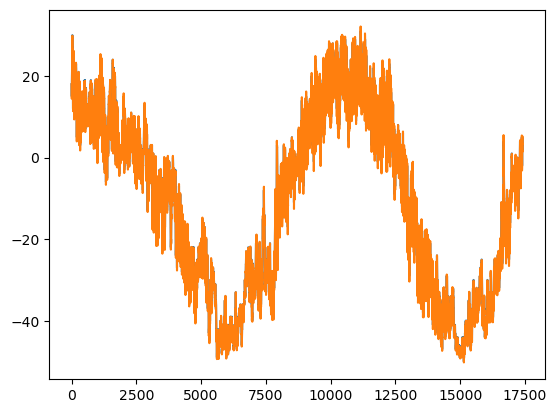

In [94]:
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

### MSE, MAE, R2 

In [95]:
y_pred = model.predict(X_test)  # X_test - тестовые данные
y_true = y_test  # y_test - фактические значения тестовых данных

# Вычисление MSE
mse3 = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse3}')

# Вычисление MAE
mae3 = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae3}')

# Вычисление R^2
r2_3 = r2_score(y_true, y_pred)
print(f'R-squared (R^2): {r2_3}')


544/544 [==============================] - 1s 1ms/step
Mean Squared Error (MSE): 0.00014306291679880818
Mean Absolute Error (MAE): 0.008874724446840346
R-squared (R^2): 0.9977393194935256


## <b>Пример2</b>

In [41]:
model2 = Sequential()
model2.add(LSTM(50,input_shape=(window2,5)))
model2.add(Dense(1,activation='linear'))

In [42]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                11200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11251 (43.95 KB)
Trainable params: 11251 (43.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
model2.compile(loss='mse',optimizer='adam',metrics='mae')

In [45]:
history = model2.fit(X_train2, y_train2, batch_size=40, epochs=20,validation_data=(X_val2,y_val2))
history_dict4 = history.history

Epoch 1/20
8704/8704 [==============================] - 32s 4ms/step - loss: 0.0092 - mae: 0.0560 - val_loss: 0.0068 - val_mae: 0.0398
Epoch 2/20
8704/8704 [==============================] - 30s 3ms/step - loss: 0.0050 - mae: 0.0349 - val_loss: 0.0051 - val_mae: 0.0334
Epoch 3/20
8704/8704 [==============================] - 31s 4ms/step - loss: 0.0041 - mae: 0.0280 - val_loss: 0.0050 - val_mae: 0.0283
Epoch 4/20
8704/8704 [==============================] - 30s 3ms/step - loss: 0.0040 - mae: 0.0270 - val_loss: 0.0049 - val_mae: 0.0303
Epoch 5/20
8704/8704 [==============================] - 31s 4ms/step - loss: 0.0039 - mae: 0.0262 - val_loss: 0.0048 - val_mae: 0.0295
Epoch 6/20
8704/8704 [==============================] - 31s 4ms/step - loss: 0.0038 - mae: 0.0257 - val_loss: 0.0048 - val_mae: 0.0298
Epoch 7/20
8704/8704 [==============================] - 33s 4ms/step - loss: 0.0038 - mae: 0.0252 - val_loss: 0.0047 - val_mae: 0.0280
Epoch 8/20
8704/8704 [==============================] -

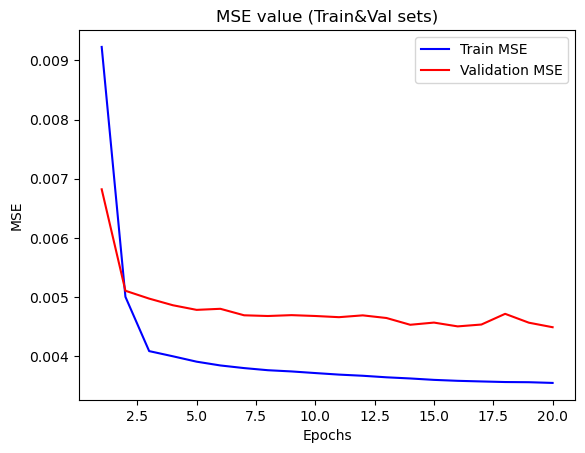

In [46]:
loss_values = history_dict4['loss']
val_loss_values = history_dict4['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Train MSE')
plt.plot(epochs, val_loss_values, 'r', label='Validation MSE')
plt.title('MSE value (Train&Val sets)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

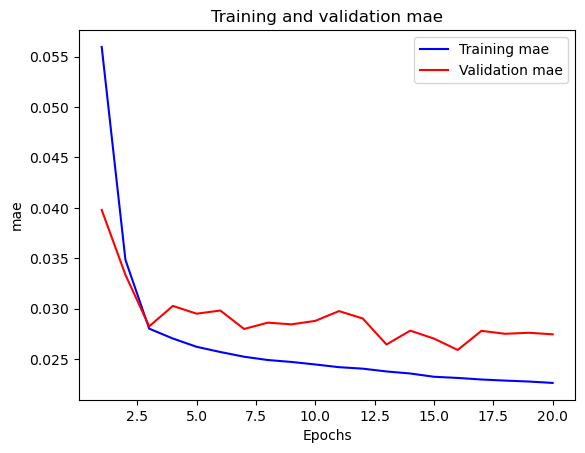

In [47]:
plt.clf()
acc_values = history_dict4['mae']
val_acc_values = history_dict4['val_mae']
plt.plot(epochs, acc_values, 'b', label='Training mae')
plt.plot(epochs, val_acc_values, 'r', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [48]:
y_pred = model2.predict(X_test2)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test2.reshape(-1,1))

print('MAE = ', round(mean_absolute_error(y_true=y_test_inv, y_pred=y_pred_inv), 3), ' K degrees')
print('R2-score = ', round(r2_score(y_test_inv, y_pred_inv), 3))

3627/3627 [==============================] - 6s 2ms/step
MAE =  0.029  K degrees
R2-score =  0.93


### MSE, MAE, R2 

In [63]:
y_pred = model2.predict(X_test2)  # X_test - тестовые данные
y_true = y_test2  # y_test - фактические значения тестовых данных

# Вычисление MSE
mse4 = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse4}')

# Вычисление MAE
mae4 = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae4}')

# Вычисление R^2
r2_4 = r2_score(y_true, y_pred)
print(f'R-squared (R^2): {r2_4}')

3627/3627 [==============================] - 5s 1ms/step
Mean Squared Error (MSE): 0.004996804613475034
Mean Absolute Error (MAE): 0.02915550557364166
R-squared (R^2): 0.9299644258366905


### Сравнение

Model Evaluation Results:
  Metric   Model 1   Model 2
0    MSE  0.000143  0.004997
1    MAE  0.008875  0.029156
2    R^2  0.997739  0.929964


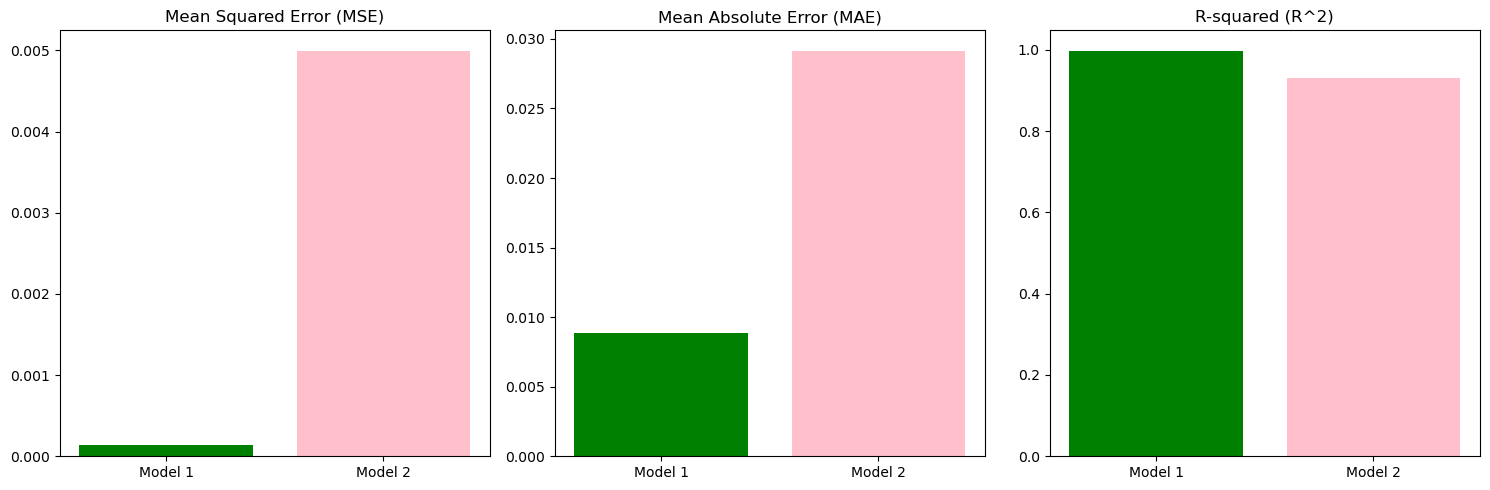

In [96]:
results = pd.DataFrame({'Metric': ['MSE', 'MAE', 'R^2'],
                        'Model 1': [mse3, mae3, r2_3],
                        'Model 2': [mse4, mae4, r2_4]})

mse = [mse3, mse4]
mae = [mae3, mae4]
r2 = [r2_3, r2_4]

colors = ['green', 'pink']
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.bar(['Model 1', 'Model 2'], mse, color=colors)
plt.title('Mean Squared Error (MSE)')

plt.subplot(132)
plt.bar(['Model 1', 'Model 2'], mae, color=colors)
plt.title('Mean Absolute Error (MAE)')

plt.subplot(133)
plt.bar(['Model 1', 'Model 2'], r2, color=colors)
plt.title('R-squared (R^2)')

plt.tight_layout()

print("Model Evaluation Results:")
print(results)
plt.show()

# <b>3. Регрессор – стек двух слоёв с LSTM (или GRU)</b>

In [97]:
regressor = Sequential()
regressor.add(LSTM(10, activation='relu', input_shape=(window,1), return_sequences=True))
regressor.add(LSTM(10, activation='relu'))
regressor.add(Dense(1, activation='linear'))

In [98]:
regressor.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 15, 10)            480       
                                                                 
 lstm_9 (LSTM)               (None, 10)                840       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1331 (5.20 KB)
Trainable params: 1331 (5.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [99]:
regressor.compile(loss='mse',optimizer='adam',metrics='mae')

In [100]:
history = regressor.fit(X_train, y_train, batch_size=32, epochs=30,validation_data=(X_val,y_val))
history_dict5 = history.history

Epoch 1/30
2539/2539 [==============================] - 16s 6ms/step - loss: 0.0030 - mae: 0.0263 - val_loss: 5.1213e-04 - val_mae: 0.0172
Epoch 2/30
2539/2539 [==============================] - 15s 6ms/step - loss: 3.2564e-04 - mae: 0.0133 - val_loss: 2.3790e-04 - val_mae: 0.0119
Epoch 3/30
2539/2539 [==============================] - 15s 6ms/step - loss: 1.6633e-04 - mae: 0.0095 - val_loss: 2.3249e-04 - val_mae: 0.0118
Epoch 4/30
2539/2539 [==============================] - 14s 6ms/step - loss: 1.3190e-04 - mae: 0.0084 - val_loss: 2.1553e-04 - val_mae: 0.0117
Epoch 5/30
2539/2539 [==============================] - 14s 6ms/step - loss: 1.1512e-04 - mae: 0.0078 - val_loss: 1.5396e-04 - val_mae: 0.0096
Epoch 6/30
2539/2539 [==============================] - 14s 6ms/step - loss: 1.0977e-04 - mae: 0.0076 - val_loss: 2.0025e-04 - val_mae: 0.0114
Epoch 7/30
2539/2539 [==============================] - 14s 6ms/step - loss: 1.0674e-04 - mae: 0.0075 - val_loss: 1.1212e-04 - val_mae: 0.0079
Epo

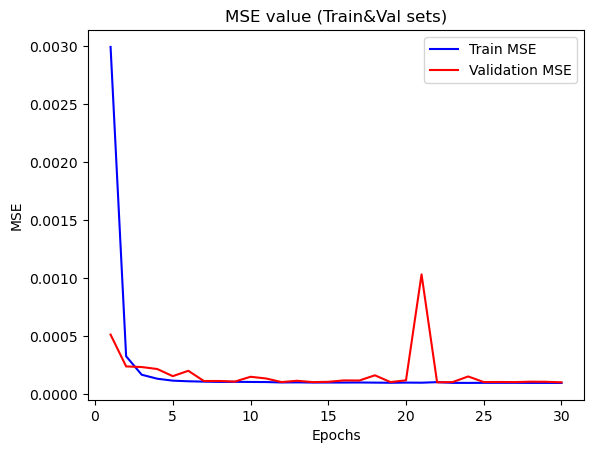

In [101]:
loss_values = history_dict5['loss']
val_loss_values = history_dict5['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Train MSE')
plt.plot(epochs, val_loss_values, 'r', label='Validation MSE')
plt.title('MSE value (Train&Val sets)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

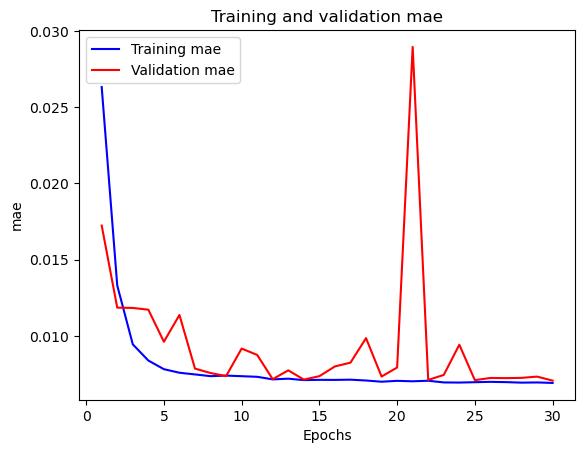

In [102]:
plt.clf()
acc_values = history_dict5['mae']
val_acc_values = history_dict5['val_mae']
plt.plot(epochs, acc_values, 'b', label='Training mae')
plt.plot(epochs, val_acc_values, 'r', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

### MSE, MAE, R2 

In [103]:
y_pred = regressor.predict(X_test)  # X_test - тестовые данные
y_true = y_test  # y_test - фактические значения тестовых данных

# Вычисление MSE
mse5 = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse5}')

# Вычисление MAE
mae5 = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae5}')

# Вычисление R^2
r2_5 = r2_score(y_true, y_pred)
print(f'R-squared (R^2): {r2_5}')

544/544 [==============================] - 1s 2ms/step
Mean Squared Error (MSE): 0.00013652216650809356
Mean Absolute Error (MAE): 0.008576877567900928
R-squared (R^2): 0.9978426764431166


## <b>Пример2</b>

In [52]:
regressor2 = Sequential()
regressor2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(window2,5)))
regressor2.add(Dropout(0.2)) 
regressor2.add(LSTM(50, activation='relu'))
regressor2.add(Dropout(0.2)) 
regressor2.add(Dense(1,activation='linear'))

In [53]:
regressor2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            11200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
regressor2.compile(loss='mse',optimizer='adam',metrics='mae')

In [55]:
history = regressor2.fit(X_train2, y_train2, batch_size=64, epochs=30,validation_data=(X_val2,y_val2))
history_dict6 = history.history

Epoch 1/30
5440/5440 [==============================] - 50s 9ms/step - loss: 0.0097 - mae: 0.0571 - val_loss: 0.0065 - val_mae: 0.0416
Epoch 2/30
5440/5440 [==============================] - 47s 9ms/step - loss: 0.0059 - mae: 0.0437 - val_loss: 0.0058 - val_mae: 0.0370
Epoch 3/30
5440/5440 [==============================] - 48s 9ms/step - loss: 0.0053 - mae: 0.0408 - val_loss: 0.0053 - val_mae: 0.0366
Epoch 4/30
5440/5440 [==============================] - 48s 9ms/step - loss: 0.0050 - mae: 0.0390 - val_loss: 0.0051 - val_mae: 0.0336
Epoch 5/30
5440/5440 [==============================] - 47s 9ms/step - loss: 0.0049 - mae: 0.0379 - val_loss: 0.0050 - val_mae: 0.0305
Epoch 6/30
5440/5440 [==============================] - 47s 9ms/step - loss: 0.0048 - mae: 0.0372 - val_loss: 0.0050 - val_mae: 0.0334
Epoch 7/30
5440/5440 [==============================] - 46s 8ms/step - loss: 0.0048 - mae: 0.0368 - val_loss: 0.0049 - val_mae: 0.0317
Epoch 8/30
5440/5440 [==============================] -

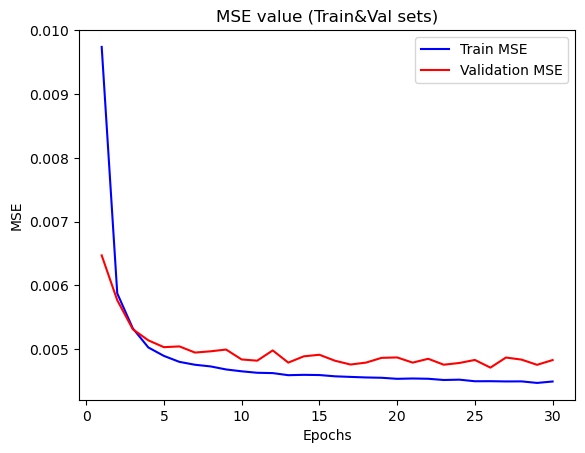

In [56]:
loss_values = history_dict6['loss']
val_loss_values = history_dict6['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Train MSE')
plt.plot(epochs, val_loss_values, 'r', label='Validation MSE')
plt.title('MSE value (Train&Val sets)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

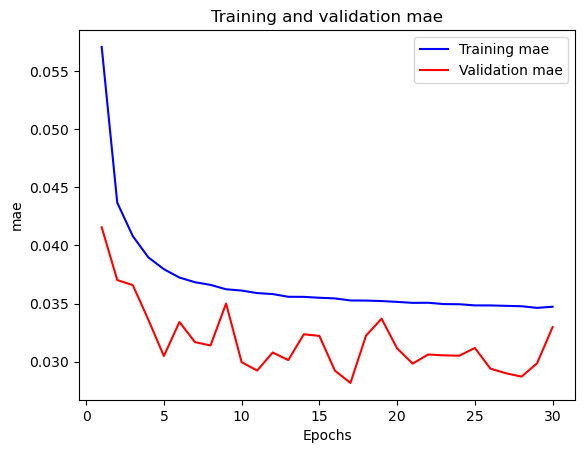

In [57]:
plt.clf()
acc_values = history_dict6['mae']
val_acc_values = history_dict6['val_mae']
plt.plot(epochs, acc_values, 'b', label='Training mae')
plt.plot(epochs, val_acc_values, 'r', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [60]:
day_index = 10

x = X_test2[day_index]  
x = x.reshape((1,) + x.shape)  
y_pred = regressor2.predict(x)  
y_pred_inv = min_max_scaler.inverse_transform(y_pred)  


y_real = y_test2[day_index]  # реальная температура для выбранного дня
y_real_inv = min_max_scaler.inverse_transform(y_real.reshape(-1, 1)) 


print('Predicted temperature:', y_pred_inv[0, 0])
print('Real temperature:', y_real_inv[0, 0])

1/1 [==============================] - 0s 14ms/step
Predicted temperature: 0.6619618
Real temperature: 0.7173913043478262


### MSE, MAE, R2 

In [62]:
y_pred = regressor2.predict(X_test2) 
y_true = y_test2 

# Вычисление MSE
mse6 = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse6}')

# Вычисление MAE
mae6 = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae6}')

# Вычисление R^2
r2_6 = r2_score(y_true, y_pred)
print(f'R-squared (R^2): {r2_6}')

3627/3627 [==============================] - 8s 2ms/step
Mean Squared Error (MSE): 0.00542937804293553
Mean Absolute Error (MAE): 0.03535806329253448
R-squared (R^2): 0.9239014454234963


### Сравнение

Model Evaluation Results:
  Metric   Model 1   Model 2
0    MSE  0.000137  0.005429
1    MAE  0.008577  0.035358
2    R^2  0.997843  0.923901


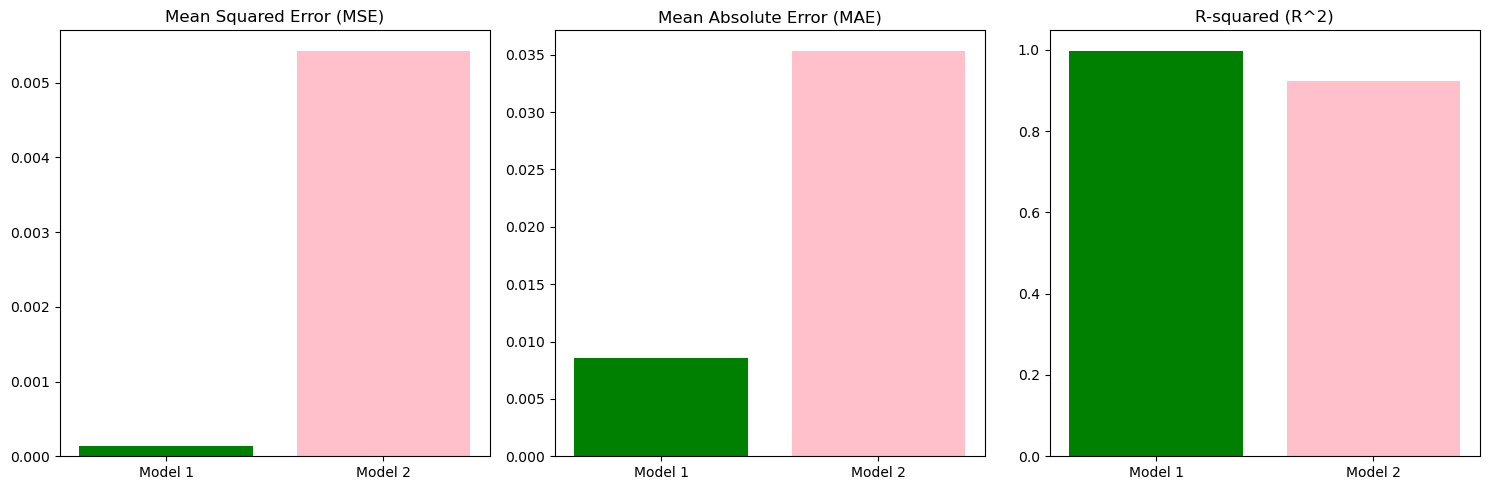

In [104]:
results = pd.DataFrame({'Metric': ['MSE', 'MAE', 'R^2'],
                        'Model 1': [mse5, mae5, r2_5],
                        'Model 2': [mse6, mae6, r2_6]})

mse = [mse5, mse6]
mae = [mae5, mae6]
r2 = [r2_5, r2_6]

colors = ['green', 'pink']
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.bar(['Model 1', 'Model 2'], mse, color=colors)
plt.title('Mean Squared Error (MSE)')

plt.subplot(132)
plt.bar(['Model 1', 'Model 2'], mae, color=colors)
plt.title('Mean Absolute Error (MAE)')

plt.subplot(133)
plt.bar(['Model 1', 'Model 2'], r2, color=colors)
plt.title('R-squared (R^2)')

plt.tight_layout()

print("Model Evaluation Results:")
print(results)
plt.show()